## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd

import os
from glob import glob
#%matplotlib inline Again, doesn't play well with jupyter lab
import matplotlib.pyplot as plt

import tensorflow as tf
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, precision_recall_curve
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

%matplotlib inline

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
!ls -ltr

total 173512
-rw-r--r-- 1 root root   1049354 Mar 21  2020  test6.dcm
-rw-r--r-- 1 root root   1049356 Mar 21  2020  test4.dcm
-rw-r--r-- 1 root root   1049354 Mar 21  2020  test5.dcm
-rw-r--r-- 1 root root   1049352 Mar 21  2020  test3.dcm
-rw-r--r-- 1 root root   1049356 Mar 21  2020  test2.dcm
-rw-r--r-- 1 root root   1049354 Mar 21  2020  test1.dcm
-rw-r--r-- 1 root root    432125 Mar 21  2020  sample_labels.csv
-rw-r--r-- 1 root root     14144 May 18  2020 'Build and train model ORIGINAL.ipynb'
-rw-r--r-- 1 root root         0 Dec 15 22:02  udacity.yml
-rw-r--r-- 1 root root         0 Dec 19 03:28  history_file
-rw-r--r-- 1 root root      1174 Dec 20 19:38  FDA_Submission_Template.md
-rw-r--r-- 1 root root   1643577 Dec 20 22:16 'Build and train model-Copy2.ipynb'
-rw-r--r-- 1 root root   1650401 Dec 20 22:42 'Build and train model-Copy1.ipynb'
-rw-r--r-- 1 root root      7203 Dec 21 01:10 'EDA ORIGINAL.ipynb'
-rw-r--r-- 1 root root   1620370 Dec 21 17:36 'Build and train model-re

In [3]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation

# Note modificaitons to the path for local machine
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')

# Another edit to path here
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(6)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
101314,00026912_000.png,Atelectasis|Pneumothorax,0,26912,55,F,PA,2992,2991,0.143000,0.143000,NaN,/data/images_011/images/00026912_000.png
77751,00019116_000.png,No Finding,0,19116,39,F,PA,2992,2991,0.143000,0.143000,NaN,/data/images_009/images/00019116_000.png
107839,00029156_003.png,Infiltration|Nodule,3,29156,45,M,PA,2021,2021,0.194311,0.194311,NaN,/data/images_012/images/00029156_003.png
55676,00013925_003.png,No Finding,3,13925,36,M,PA,2992,2991,0.143000,0.143000,NaN,/data/images_007/images/00013925_003.png
57450,00014251_024.png,No Finding,24,14251,70,M,PA,2990,2991,0.143000,0.143000,NaN,/data/images_007/images/00014251_024.png
68501,00016919_001.png,No Finding,1,16919,40,F,AP,2500,2048,0.168000,0.168000,NaN,/data/images_008/images/00016919_001.png


In [4]:
all_xray_df['Finding Labels'].isna().sum()

0

In [5]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
# Mostly a rehash of previous code. First, a quick confirmation that we're not dealing with any empty labels
all_xray_df['Finding Labels'].isna().sum()

0

In [6]:
unique_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
unique_labels

array(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'], dtype='<U18')

In [7]:
for x in unique_labels:
    all_xray_df[x] = [x in label for label in all_xray_df['Finding Labels']]

# After a 'target must be string' error, quick adjustment
all_xray_df['target'] = np.where(all_xray_df['Pneumonia'], "Pneumonia", "No Pneumonia") 

In [8]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
# In this instance, we can use what was created, above. 

# Quick review
all_xray_df.sample(6)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,target
103398,00027585_000.png,Cardiomegaly,0,27585,61,F,PA,2886,2991,0.143000,...,False,False,False,False,False,False,False,False,False,No Pneumonia
71032,00017516_000.png,No Finding,0,17516,46,M,PA,2774,2991,0.143000,...,False,False,False,False,True,False,False,False,False,No Pneumonia
49142,00012470_007.png,No Finding,7,12470,15,M,AP,2500,2048,0.168000,...,False,False,False,False,True,False,False,False,False,No Pneumonia
37658,00009912_003.png,No Finding,3,9912,27,M,AP,2500,2048,0.168000,...,False,False,False,False,True,False,False,False,False,No Pneumonia
8825,00002333_000.png,No Finding,0,2333,62,M,PA,2021,2021,0.194311,...,False,False,False,False,True,False,False,False,False,No Pneumonia
25349,00006670_014.png,No Finding,14,6670,34,M,AP,2500,2048,0.168000,...,False,False,False,False,True,False,False,False,False,No Pneumonia


## Create your training and testing data:
**Note one**: We have some decisions to make regarging how 'pure' we want the target to be: 
* Option one: restrict to instances of *just* pneumonia
* Option two: train on instances of pneumonia, accepting the presence of other potential diseases. 

**Note two**: we have an issue here where a subject's series could be sampled in both the training and test sets. According to some preliminary analysis, there _are_ cases where the series from a subject can be both negative and positive for the classification; however, in cases where this is not the case (and I suspect this is the majority), it will be necessary to stratify subjects across groups to avoid leakage.

In a nuttshell: we want to ensure that the algorithm is learning signal associated with the label, not signal associated with the _individual_ which it can subsequently use (by virtue of knowledge gained in training) to reidentify the label.

**also note that this is most likely going to really hurt performance, but in a valid way -- this was leakage**

**Note three**: class imbalance. 

In [9]:
def create_splits(input_frame):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    # A more elaborate stratified splits
    
    # Groupby patient id, and use the sum of the binary classification to establish of this 
    # has ever had pneumonia (not ideal, but let's go with it)
    patient_df = input_frame.groupby('Patient ID').sum().reset_index()

    # Relabel pneumonia label
    patient_df['Pneumonia'] = np.where(patient_df['Pneumonia'] >= 1, 1, 0)

    # Run a stratified split on subjects, balancing across pneumonia
    train_data_sub, val_data_sub = train_test_split(patient_df, 
                                            test_size=0.2, 
                                            stratify=patient_df['Pneumonia'])

    # Use the balanced patient id values to subset from the original data frame, and create the splits. 
    train_data = input_frame[input_frame['Patient ID'].isin(train_data_sub['Patient ID'])]
    val_data = input_frame[input_frame['Patient ID'].isin(val_data_sub['Patient ID'])]
    
    # Balance the test set. Here, it is less important to respect how images are allocated to patients;
    # more important to rebalance the prevalence of labels. Here, we can do a random negative selection.
    
    # Well, so this is going to be a hack (again), but it should do the job
    train_data_pos =  train_data[train_data['Pneumonia'] == 1]
    train_data_neg = train_data[train_data['Pneumonia'] == 0]
    
    train_data = train_data_pos.append(train_data_neg.sample(len(train_data_pos)))
    
    # I Wasn't going to do this but I think the validation set is going to make more sense if it's 
    # balanced as well
    val_data_pos =  val_data[val_data['Pneumonia'] == 1]
    val_data_neg = val_data[val_data['Pneumonia'] == 0]
    
    val_data = val_data_pos.append(val_data_neg.sample(len(val_data_pos)))
    
    return train_data, val_data

In [10]:
# Owing to the fact that there are not an equal number of videos per person, this method is not going to 
# results in a _perfectly_ balanced split, but it should be close. Review. 
train_data, val_data = create_splits(all_xray_df)

def check_split(train, val):
    
    print("Training composition")
    print(train['Pneumonia'].value_counts())
    print(train['Pneumonia'].value_counts(normalize=True))
    
    print('-------------------')
    
    print("Validation composition")
    print(val['Pneumonia'].value_counts())
    print(val['Pneumonia'].value_counts(normalize=True))

check_split(train_data, val_data)

Training composition
True     1155
False    1155
Name: Pneumonia, dtype: int64
True     0.5
False    0.5
Name: Pneumonia, dtype: float64
-------------------
Validation composition
True     276
False    276
Name: Pneumonia, dtype: int64
True     0.5
False    0.5
Name: Pneumonia, dtype: float64


In [11]:
# Just to be clear, contast this with the values we were getting from the conventional method
train_data_check, val_data_check = train_test_split(all_xray_df, 
                                            test_size=0.2, 
                                            stratify=all_xray_df['Pneumonia'])

check_split(train_data_check, val_data_check)

Training composition
False    88551
True      1145
Name: Pneumonia, dtype: int64
False    0.987235
True     0.012765
Name: Pneumonia, dtype: float64
-------------------
Validation composition
False    22138
True       286
Name: Pneumonia, dtype: int64
False    0.987246
True     0.012754
Name: Pneumonia, dtype: float64


We've now ensured that subject do not appear in both train _and_ test splits. 

Additional observation: this is _not_ a large number of target cases but it's as balanced as we could hope for. As  additional confirmation, as well as accounting for the correct stratification of subjects, it yields comparable balance to what is achieved through `train_test_split`.

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [12]:
# So, dang, I need to make more edits to these paths. This time, what we have in the data frame.

def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    # At present, this is a replication of what was used earlier
    my_idg = ImageDataGenerator(rescale=1. / 255.0, # I believe this is going to standarsize the images...
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.1, 
                              width_shift_range = 0.1,
                              rotation_range = 20, 
                              shear_range = 0.1,
                              zoom_range= 0.1
                        )
    
    return my_idg


def make_train_gen(train_df):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    # Todo
    # Here, we're going to apply aumentation in the process of reading in the training set
    my_train_idg = my_image_augmentation()
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'target',
                                         class_mode = 'binary',
                                         target_size = (224, 224), # Let's assume we start prototyping with VGG16
                                         batch_size = 64 # Do I have a good reason to do something different?
                                         )
    
    return train_gen


def make_val_gen(val_data):
    
    # Todo
    # As above, apply aumentation in the process of reading in the validation set
    my_val_idg = my_image_augmentation()
    
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'target',
                                             class_mode = 'binary',
                                             target_size = (224, 224), 
                                             batch_size = 64 
                                             )
    
    return val_gen

In [13]:
# At this point, it looks as though we presume to have run these functions... 
train_data, val_data = create_splits(all_xray_df)

#my_idg = my_image_augmentation() call from within functions. 

train_gen = make_train_gen(train_data)
val_gen = make_val_gen(val_data)

Found 2254 validated image filenames belonging to 2 classes.
Found 608 validated image filenames belonging to 2 classes.


In [14]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

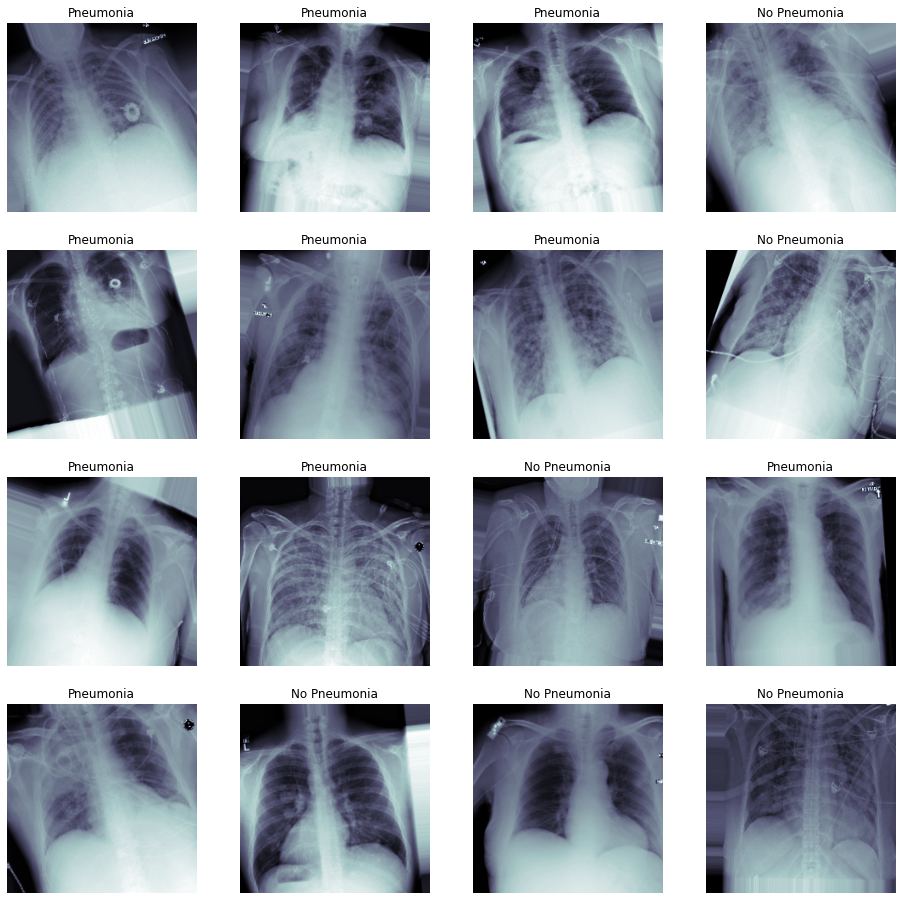

In [15]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [16]:
def load_pretrained_model():
    
    tune_layer = "block5_pool"
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer(tune_layer)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    
    # Confirm that the freeze has been applied
    for layer in vgg_model.layers:
        print(layer.name, layer.trainable)  
    
    # Todo
    return vgg_model

In [17]:
def build_my_model():
    
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    # All of this is stock standard from exercises, earlier. Get things running, then optimize.
    
    # After some brief experimentation, I'm going to increase the prevalence of sigmoid activation
    # functions in the later layers, in the hope that this will decrease any vanishing gradient effect.
    
    # Load and add vgg16 backbone
    my_model = Sequential()
    
    # Load and add vgg16 backbone
    starter_model = load_pretrained_model()
    my_model.add(starter_model)

    my_model.add(Flatten())
    
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1024, activation='relu'))

    my_model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(lr=1e-4) 
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    # Why are we defining this stuff outside of the function? If this is convention, fine. 
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    my_model.summary()
    
    return my_model


## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [18]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

weight_path="{}_my_model.best.hdf5".format('xray_class')

# Note adjustments here
checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_binary_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'auto', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_binary_accuracy', 
                      mode= 'auto', 
                      patience=5)

callbacks_list = [checkpoint, early]

### Start training! 

In [19]:
# train your model

#Todo
my_model = build_my_model()

553467904/553467096 [==============================] - 8s 0us/step
input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None

In [20]:
history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 10, 
                          callbacks = callbacks_list)

Epoch 1/10
36/36 [==============================] - 66s 2s/step - loss: 0.7976 - binary_accuracy: 0.5266 - val_loss: 0.6345 - val_binary_accuracy: 0.6250

Epoch 00001: val_binary_accuracy improved from -inf to 0.62500, saving model to xray_class_my_model.best.hdf5
Epoch 2/10
36/36 [==============================] - 60s 2s/step - loss: 0.6769 - binary_accuracy: 0.5847 - val_loss: 0.6307 - val_binary_accuracy: 0.6719

Epoch 00002: val_binary_accuracy improved from 0.62500 to 0.67188, saving model to xray_class_my_model.best.hdf5
Epoch 3/10
36/36 [==============================] - 58s 2s/step - loss: 0.6780 - binary_accuracy: 0.5994 - val_loss: 0.5948 - val_binary_accuracy: 0.6875

Epoch 00003: val_binary_accuracy improved from 0.67188 to 0.68750, saving model to xray_class_my_model.best.hdf5
Epoch 4/10
36/36 [==============================] - 59s 2s/step - loss: 0.6653 - binary_accuracy: 0.6074 - val_loss: 0.6181 - val_binary_accuracy: 0.6250

Epoch 00004: val_binary_accuracy did not imp

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [21]:
# CHECKPOINT 
# Kill this once you're satisfied with the model

# Save files
pd.DataFrame.from_dict(history.history).to_csv('history.csv',index=False)

# load files
# valX, valY = val_gen.next()
# my_model = build_my_model()
# # history = pd.read_csv('history.csv')

In [22]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)

# That was frustrating: `new_model`? Was that a typo..?
pred_Y = my_model.predict(valX, batch_size = 64, verbose = True)

64/64 [==============================] - 1s 10ms/step


In [23]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    # Pull the stuff that we need (not so sure that we're going to use the threshold...)
    fpr, tpr, thresholds =  roc_curve(t_y, p_y)
    plt.plot(fpr, tpr, color='purple')
    plt.title('AUC: ' + str(round(auc(fpr, tpr), 2)))
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    
    
## what other performance statistics do you want to include here besides AUC? 

def plot_precision_recall(t_y, p_y):
    
    # Note that this is going to output what the precision recall curve requires
    precision, recall, thresholds =  precision_recall_curve(t_y, p_y)
    plt.plot(recall, precision, color = 'green')
    plt.title('Precision recall curve')
    plt.xlabel('recall')
    plt.ylabel('precision')


def plot_F1_by_treshold(t_y, p_y):
    
    prec, recall, thresholds =  precision_recall_curve(t_y, p_y)
    
    f1_scores = 2*(prec*recall)/(prec+recall)

    sns.lineplot(thresholds, f1_scores[1:], color='orange')

    plt.xlabel("Threshold")
    plt.ylabel("F1 score")
    
    return


def plot_precision_by_treshold(t_y, p_y):
    
    prec, recall, thresholds =  precision_recall_curve(t_y, p_y)

    sns.lineplot(thresholds, prec[1:], color='red')

    plt.xlabel("Threshold")
    plt.ylabel("Precision")
    
    return
   

def plot_recall_by_treshold(t_y, p_y):
    
    prec, recall, thresholds =  precision_recall_curve(t_y, p_y)

    sns.lineplot(thresholds, recall[1:], color='magenta')

    plt.xlabel("Threshold")
    plt.ylabel("Precision")
    
    return    

    
# Time permitting, consider a confusion matrix (once you've settled on a treshold)    
    
    
#Also consider plotting the history of your model training:
def plot_history(history):
    
    # Todo
    plt.plot(history.history['loss'],label="Training loss")
    plt.plot(history.history['val_loss'], label='Validation loss')
    
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    plt.legend()
    plt.show()
    
    return

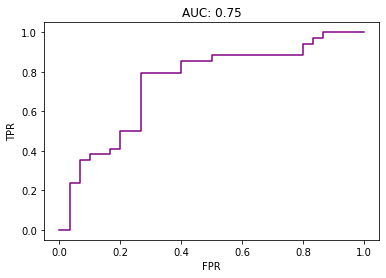

In [24]:
## plot figures
plot_auc(valY, pred_Y)

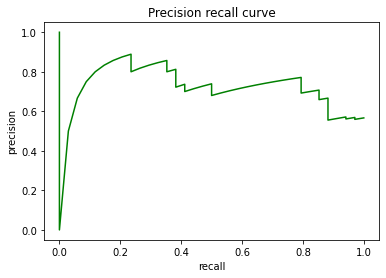

In [25]:
plot_precision_recall(valY, pred_Y)

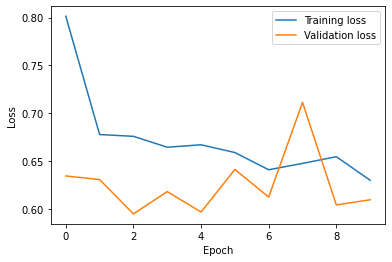

In [26]:
plot_history(history)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


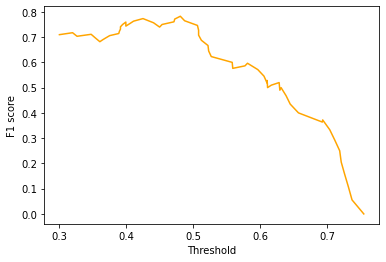

In [27]:
plot_F1_by_treshold(valY, pred_Y)

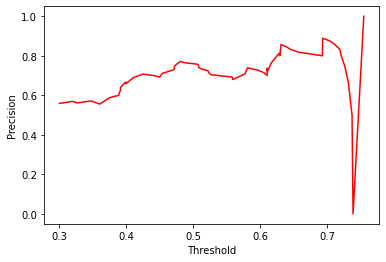

In [28]:
plot_precision_by_treshold(valY, pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [29]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

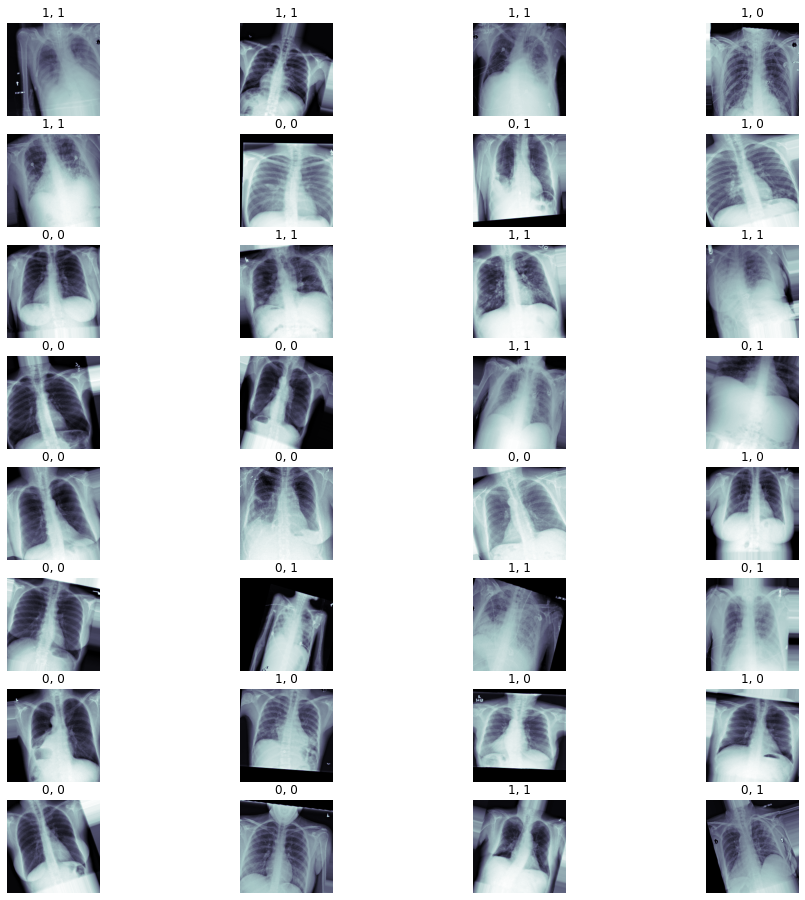

In [35]:
## Let's look at some examples of predicted v. true with our best model: 
YOUR_THRESHOLD = 0.63

# Todo

fig, m_axs = plt.subplots(8, 4, figsize = (16, 16))
i = 0

# Bug here? testY == valY
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [33]:
## Just save model architecture to a .json:
model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)